In [10]:
# Libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [8]:
# Path to the same DB
DB_PATH = Path("../data/processed/HVT_Analysis_Final.db")

# Load Table
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM Physician_Nexus_Cleaned", conn)
conn.close()

print(f" Loaded {len(df)} physicians")
display(df.head(5))

 Loaded 87297 physicians


,id,full_name,specialty,commercial_spend,research_spend,total_spend,primary_manufacturer
0,14,Anita Gill,Neurology,20.00,0.0,20.00,Csl Behring
1,18,Moustafa Banna,Cardiology,2527.62,0.0,2527.62,"Heartflow, Inc."
2,36,Yolanda Zarate,Neurology,1163.77,0.0,1163.77,Abbvie Inc.
3,37,Joseph Poitier,Neurology,313.93,0.0,313.93,Abbvie Inc.
4,43,Mahta Ostadian,Neurology,184.49,0.0,184.49,Abbvie Inc.


In [12]:
# A. Influence Ratio (0.0 to 1.0)
# High = Scientific Researcher | Low = Commercial Prescriber
df['influence_ratio'] = (df['research_spend'] / df['total_spend']).fillna(0)

# B. Log Spend (The "Outlier Tamer")
# We use log1p so $0 stays 0, and $17M becomes ~16.6
df['log_total_spend'] = np.log1p(df['total_spend'])

print("Features Engineered: 'influence_ratio' and 'log_total_spend'")

Features Engineered: 'influence_ratio' and 'log_total_spend'


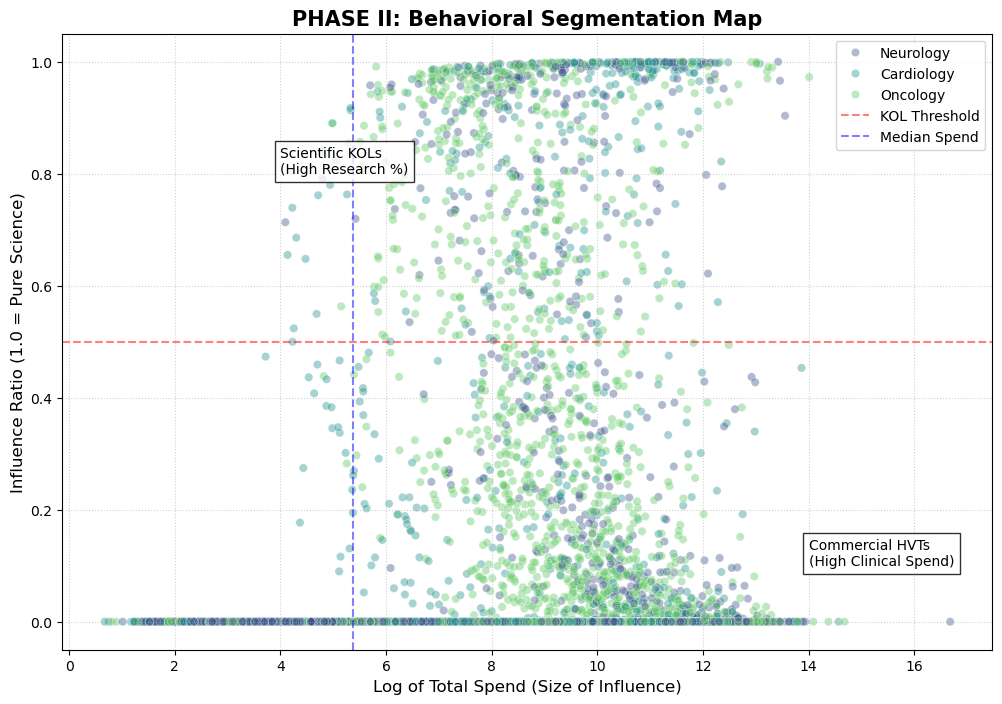

In [13]:
# 1. Setup the figure
plt.figure(figsize=(12, 8))

# 2. Create the Scatter Plot
# Use 'hue' by specialty to see if therapeutic areas cluster differently
sns.scatterplot(
    data=df, 
    x='log_total_spend', 
    y='influence_ratio', 
    hue='specialty', 
    alpha=0.4, 
    palette='viridis'
)

# 3. Add benchmark lines for "Quadrants"
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='KOL Threshold')
plt.axvline(x=df['log_total_spend'].median(), color='b', linestyle='--', alpha=0.5, label='Median Spend')

# 4. Labeling the "Discovery Zones"
plt.text(4, 0.8, "Scientific KOLs\n(High Research %)", fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(14, 0.1, "Commercial HVTs\n(High Clinical Spend)", fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.title('PHASE II: Behavioral Segmentation Map', fontsize=15, fontweight='bold')
plt.xlabel('Log of Total Spend (Size of Influence)', fontsize=12)
plt.ylabel('Influence Ratio (1.0 = Pure Science)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

# Save this to your reports folder too!
plt.savefig("../reports/Nexus_Behavioral_Map.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Create a dummy "Concentration" score
# A higher score means they are more 'concentrated' in their primary manufacturer
df['loyalty_score'] = (df['commercial_spend'] / df['total_spend']).round(4)

print("All features generated: Influence Ratio, Log Spend, and Loyalty Score.")

All features generated: Influence Ratio, Log Spend, and Loyalty Score.


In [15]:
# Filter for our top 10 $1M+ outliers
high_rollers = df[df['total_spend'] > 1_000_000].copy()

# Calculate their 'Manufacturer Concentration'
# This shows how much of their total spend comes from their Primary Manufacturer
high_rollers['mfg_loyalty_pct'] = (high_rollers['commercial_spend'] / high_rollers['total_spend']) * 100

print("LOYALTY ANALYSIS: The $1M+ Outliers")
print("-" * 60)
display(high_rollers[['full_name', 'specialty', 'primary_manufacturer', 'total_spend', 'mfg_loyalty_pct']])

LOYALTY ANALYSIS: The $1M+ Outliers
------------------------------------------------------------


,full_name,specialty,primary_manufacturer,total_spend,mfg_loyalty_pct
11342,Ivan Osorio,Neurology,"Livanova Usa, Inc.",17456052.97,100.000000
13739,Matthew Budoff,Cardiology,Novo Nordisk Inc,1046892.53,54.678395
18450,Leslie Citrome,Neurology,"Teva Pharmaceuticals Usa, Inc.",1027564.85,100.000000
24967,Rakesh Jain,Neurology,"Teva Pharmaceuticals Usa, Inc.",1124859.37,100.000000
38268,Khaldoun Almhanna,Oncology,"Trisalus Life Sciences, Inc.",1211074.57,2.756597
39890,David Jacofsky,Oncology,Stryker Corporation,1743111.79,100.000000
44037,Roger Hajjar,Cardiology,Asklepios Biopharmaceutical Inc.,2114077.40,100.000000
46259,Andrew Cutler,Neurology,"Iti, Inc. (D/B/A Intra-Cellular Therapies, Inc.)",1080855.50,100.000000
64260,Neil Love,Oncology,"Janssen Scientific Affairs, Llc",1310000.00,100.000000
77066,John Pesando,Oncology,"Beckman Coulter, Inc.",2366194.17,100.000000


In [18]:
# Create column for more analytic insights in charts
# We multiply by 100 to get a percentage (0-100)
df['mfg_loyalty_pct'] = (df['commercial_spend'] / df['total_spend'] * 100).fillna(0)

print("✅ Column 'mfg_loyalty_pct' created successfully.")
print(f"Sample values:\n{df['mfg_loyalty_pct'].head()}")

✅ Column 'mfg_loyalty_pct' created successfully.
Sample values:
0    100.0
1    100.0
2    100.0
3    100.0
4    100.0
Name: mfg_loyalty_pct, dtype: float64


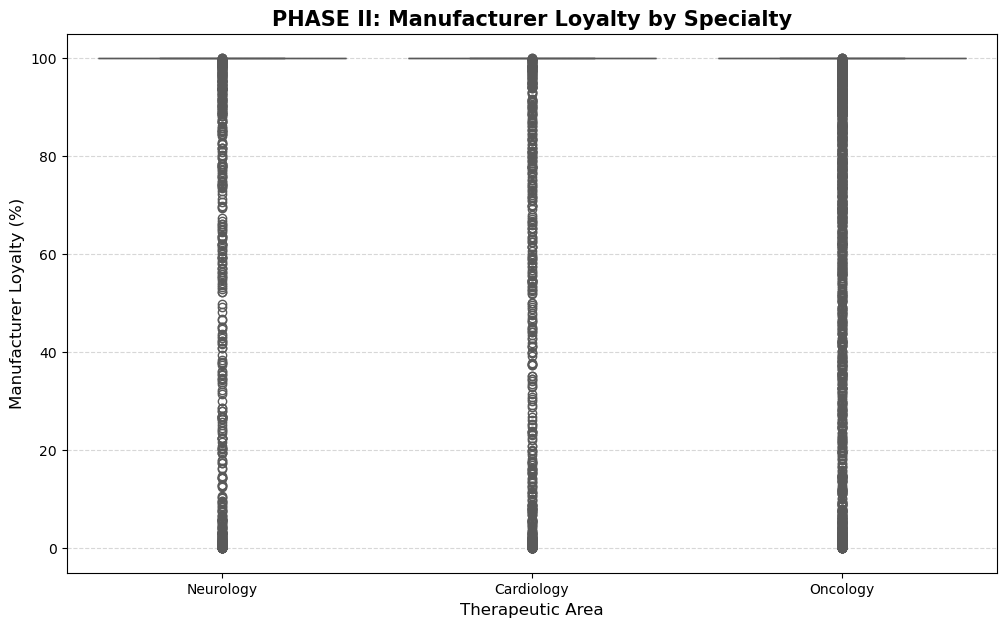

In [19]:
# 1. Setup the figure
plt.figure(figsize=(12, 7))

# 2. Create the Boxplot
# A Boxplot shows the median, quartiles, and outliers of loyalty
sns.boxplot(
    data=df, 
    x='specialty', 
    y='mfg_loyalty_pct', 
    palette='Set2', 
    hue='specialty', 
    legend=False
)

# 3. Add Labels and Formatting
plt.title('PHASE II: Manufacturer Loyalty by Specialty', fontsize=15, fontweight='bold')
plt.xlabel('Therapeutic Area', fontsize=12)
plt.ylabel('Manufacturer Loyalty (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 4. Save the Insight
plt.savefig("../reports/Loyalty_By_Specialty.png", dpi=300, bbox_inches='tight')
plt.show()

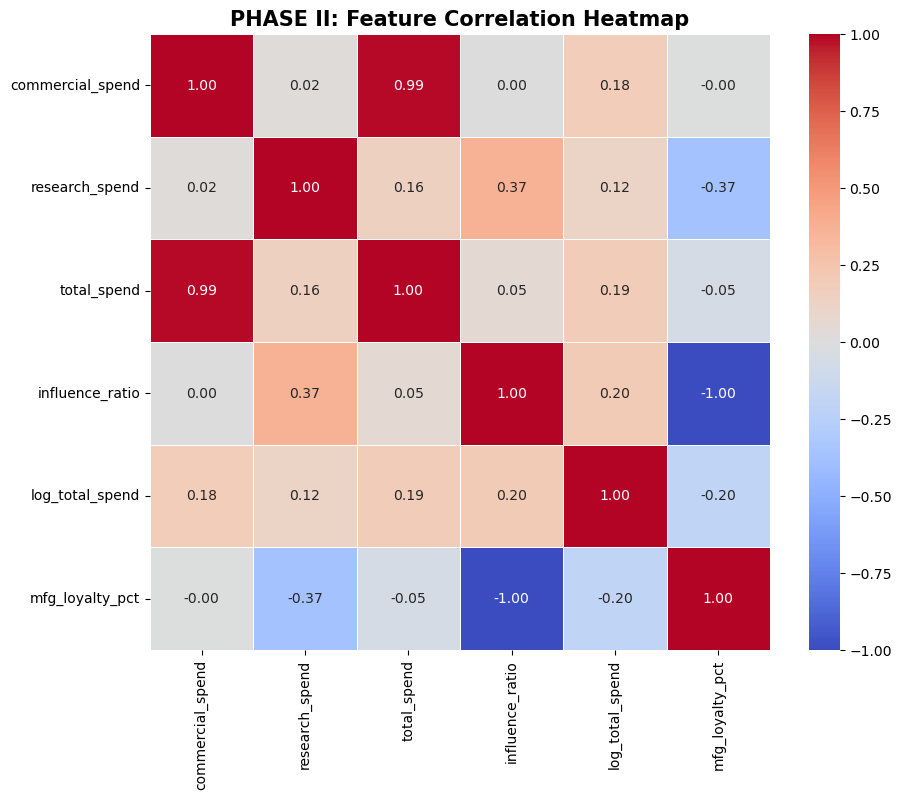

In [20]:
# 1. Select the numerical features for correlation
features = ['commercial_spend', 'research_spend', 'total_spend', 
            'influence_ratio', 'log_total_spend', 'mfg_loyalty_pct']

# 2. Calculate the Correlation Matrix
corr_matrix = df[features].corr()

# 3. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('PHASE II: Feature Correlation Heatmap', fontsize=15, fontweight='bold')
plt.show()

##### Save Table

In [21]:
# Final save to the Model-Ready table
target_conn = sqlite3.connect(DB_PATH)
df.to_sql('Physician_Nexus_Model', target_conn, if_exists='replace', index=False)
target_conn.close()

print("Table 'Physician_Nexus_Model' is locked and loaded for the ML phase.")

Table 'Physician_Nexus_Model' is locked and loaded for the ML phase.
